## Split CIFAR-10 into training, validation, and testing sets

In [2]:
##########################
### SETTINGS
##########################

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
lr = 0.0001
num_epochs = 60
batch_size = 32

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


## Visualize image for each class

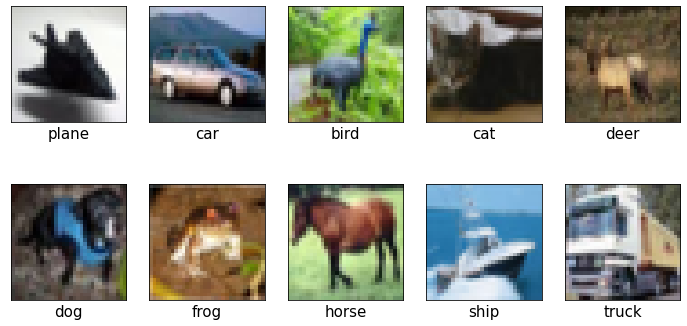

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

net = models.vgg16(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Device: cuda:0
Number of trainable parameters: 138357544


## Training

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))




[epoch 1] loss: 0.03181 accuracy: 0.6685 val loss: 0.01986 val accuracy: 0.7935
[epoch 2] loss: 0.01832 accuracy: 0.8081 val loss: 0.01590 val accuracy: 0.8309
[epoch 3] loss: 0.01506 accuracy: 0.8427 val loss: 0.01454 val accuracy: 0.8477
[epoch 4] loss: 0.01297 accuracy: 0.8664 val loss: 0.01609 val accuracy: 0.8323
[epoch 5] loss: 0.01124 accuracy: 0.8819 val loss: 0.01324 val accuracy: 0.8577
[epoch 6] loss: 0.01005 accuracy: 0.8937 val loss: 0.01447 val accuracy: 0.8587
[epoch 7] loss: 0.00902 accuracy: 0.9074 val loss: 0.01393 val accuracy: 0.8641
[epoch 8] loss: 0.00820 accuracy: 0.9156 val loss: 0.01407 val accuracy: 0.8614
[epoch 9] loss: 0.00773 accuracy: 0.9204 val loss: 0.01422 val accuracy: 0.8642
[epoch 10] loss: 0.00696 accuracy: 0.9268 val loss: 0.01229 val accuracy: 0.8840
[epoch 11] loss: 0.00636 accuracy: 0.9329 val loss: 0.01232 val accuracy: 0.8790
[epoch 12] loss: 0.00604 accuracy: 0.9386 val loss: 0.01223 val accuracy: 0.8826
[epoch 13] loss: 0.00555 accuracy: 0.

## Plotting training statistics

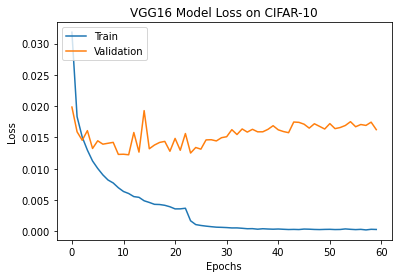

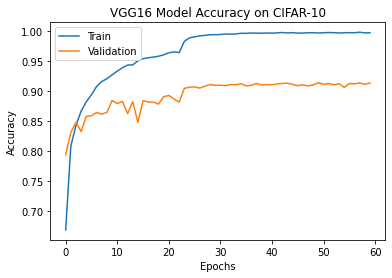

In [13]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('VGG16 Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('VGG16 Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [8]:
from google.colab import files

torch.save(net.state_dict(), 'checkpoint.pth')
# download checkpoint file
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
net.load_state_dict(torch.load('checkpoint.pth'))

<All keys matched successfully>

## Testing

In [10]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 91.52 %


## Visualize wrongly classified image for each class

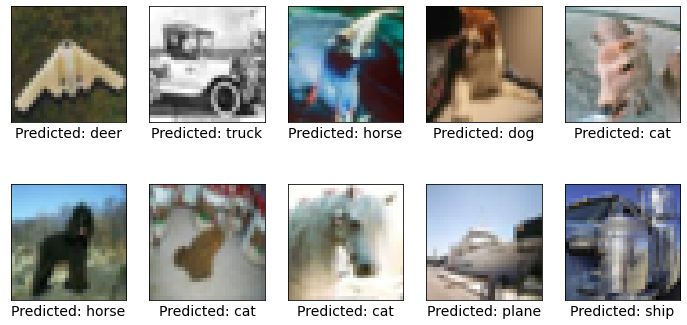

In [11]:
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1